In [20]:
from sklearn.datasets import load_iris

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from seaborn import set_style
set_style("whitegrid")

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [21]:
# Load the data.
data_path = "../Data/"

date = pd.read_csv(data_path + "dim_date.csv")
claims = pd.read_csv(data_path + "dim_claims.csv")
pa = pd.read_csv(data_path + "dim_pa.csv")
bridge = pd.read_csv(data_path + "bridge.csv")

# Join claims with bridge, in df dataframe.
df = claims.copy()
df = df.set_index('dim_claim_id').join(bridge.set_index('dim_claim_id'))

# Join the pa with rejected claims, in pa_df dataframe.
pa_df = df.copy().dropna()
pa_df = pa_df.set_index('dim_pa_id').join(pa.set_index('dim_pa_id'))

## Map bins
## 417380 -> 0
## 417614 -> 1
## 417740 -> 2
## 999001 -> 3

pa_df['bin_no'] = 3
pa_df.loc[pa_df.bin == 417380,'bin_no'] = 0
pa_df.loc[pa_df.bin == 417614,'bin_no'] = 1
pa_df.loc[pa_df.bin == 417740,'bin_no'] = 2

## Map drugs
## A -> 0
## B -> 1
## C -> 2

pa_df['drug_no'] = 0
pa_df.loc[pa_df.drug == 'B','drug_no'] = 1
pa_df.loc[pa_df.drug == 'C','drug_no'] = 2


## Map reject codes
## 70.0 -> 0
## 75.0 -> 1
## 76.0 -> 2

pa_df['reject_no'] = 0
pa_df.loc[pa_df.reject_code == 75.0,'reject_no'] = 1
pa_df.loc[pa_df.reject_code == 76.0,'reject_no'] = 2

#For stratification, concatenate the features that will be used in the model

concat_features = ['bin_no','drug_no', 'reject_no', 'correct_diagnosis', 'tried_and_failed', 'contraindication']

pa_df['feature_id'] = ''

for feature in concat_features:
    pa_df['feature_id'] = pa_df['feature_id'] + pa_df[feature].astype(str)
    
pa_df['concat_all'] = pa_df['feature_id'] + pa_df['pa_approved'].astype(str)

In [22]:
random_state = 2;

# Perform train-test split.
pa_train, pa_test = train_test_split( pa_df.copy(),
                                      test_size = .2,
                                      random_state = random_state,
                                      shuffle = True,
                                      stratify = pa_df['concat_all'])

In [23]:
features = concat_features

myModels = [DecisionTreeClassifier(random_state=random_state),
          AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                             random_state=random_state,
                             learning_rate=0.1),
          RandomForestClassifier(random_state=random_state,
                                 max_depth = 2,
                                 n_estimators = 100),
          ExtraTreesClassifier(random_state=random_state),
          GradientBoostingClassifier(random_state=random_state),
          KNeighborsClassifier(),
          LogisticRegression(random_state = random_state),
          LinearDiscriminantAnalysis(),
          CatBoostClassifier(iterations=10,
                             learning_rate=1,
                             depth=4),
          XGBClassifier(n_estimators=11,
                        learning_rate=.35,
                        max_depth=4)]

length = len(myModels)
predictions = np.zeros(length)
accuracies = np.zeros(length)
precisions = np.zeros(length)
recalls = np.zeros(length)
f1s = np.zeros(length)
roc_aucs = np.zeros(length)


for index ,model in enumerate(myModels):
    # Fit  the model and get the predictions
    model.fit(pa_train[features].values, pa_train['pa_approved'])
    y_pred = model.predict(pa_test[features].values)
    predictions = [round(value) for value in y_pred]

    # evaluate predictions for test data
    accuracies[index] = accuracy_score(pa_test['pa_approved'], predictions)
    precisions[index] = precision_score(pa_test['pa_approved'], predictions)
    recalls[index] = recall_score(pa_test['pa_approved'], predictions)
    f1s[index] = f1_score(pa_test['pa_approved'], predictions)
    roc_aucs[index] = roc_auc_score(pa_test['pa_approved'], predictions)

    
    


0:	learn: 0.4204707	total: 42.7ms	remaining: 384ms
1:	learn: 0.3847522	total: 85.2ms	remaining: 341ms
2:	learn: 0.3768410	total: 125ms	remaining: 292ms
3:	learn: 0.3753647	total: 168ms	remaining: 252ms
4:	learn: 0.3736660	total: 215ms	remaining: 215ms
5:	learn: 0.3724170	total: 254ms	remaining: 170ms
6:	learn: 0.3724026	total: 297ms	remaining: 127ms
7:	learn: 0.3721193	total: 340ms	remaining: 85.1ms
8:	learn: 0.3714111	total: 388ms	remaining: 43.1ms
9:	learn: 0.3713927	total: 431ms	remaining: 0us


C:\Users\ozkan\anaconda3\envs\Keras\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [24]:
# Import everything for neural network model.

import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras import Input
from keras import Model

## For y when training the network
from keras.utils.np_utils import to_categorical


In [25]:
# Build the NN model
## Create an empty model object here
model1 =  models.Sequential() 

## Add the Dense layes with 50 nodes, 20 and 10 nodes:
model1.add(layers.Dense(50, activation='relu', input_shape=(6,)))
model1.add( layers.Dense(20, activation='relu'))


## Add the Dense output layer.
model1.add(layers.Dense(2, activation='softmax'))

## Compile the network
model1.compile(optimizer = 'rmsprop' ,
                 loss = 'categorical_crossentropy' ,
                 metrics = ['accuracy'] )

## Train the model for 40 epochs
n_epochs = 40

## fit the model 
history1 = model1.fit(pa_train[features].values,
                       to_categorical(pa_train['pa_approved']),
                       epochs = n_epochs,
                       batch_size = 512,
                       validation_data = (pa_test[features].values, to_categorical(pa_test['pa_approved'])))


Epoch 1/40
869/869 [==============================] - 5s 4ms/step - loss: 0.3921 - accuracy: 0.8068 - val_loss: 0.3755 - val_accuracy: 0.8139
Epoch 2/40
869/869 [==============================] - 4s 4ms/step - loss: 0.3741 - accuracy: 0.8137 - val_loss: 0.3727 - val_accuracy: 0.8140
Epoch 3/40
869/869 [==============================] - 4s 4ms/step - loss: 0.3732 - accuracy: 0.8140 - val_loss: 0.3724 - val_accuracy: 0.8139
Epoch 4/40
869/869 [==============================] - 3s 4ms/step - loss: 0.3728 - accuracy: 0.8137 - val_loss: 0.3723 - val_accuracy: 0.8138
Epoch 5/40
869/869 [==============================] - 3s 4ms/step - loss: 0.3725 - accuracy: 0.8140 - val_loss: 0.3729 - val_accuracy: 0.8136
Epoch 6/40
869/869 [==============================] - 3s 4ms/step - loss: 0.3723 - accuracy: 0.8140 - val_loss: 0.3714 - val_accuracy: 0.8142
Epoch 7/40
869/869 [==============================] - 3s 4ms/step - loss: 0.3722 - accuracy: 0.8140 - val_loss: 0.3725 - val_accuracy: 0.8140
Epoch 

In [26]:
myModels.append(model1)

In [33]:
y_pred

array([[0.22678818, 0.7732118 ],
       [0.68328357, 0.3167164 ],
       [0.42270076, 0.5772993 ],
       ...,
       [0.51046664, 0.48953342],
       [0.75722575, 0.24277428],
       [0.08669147, 0.9133085 ]], dtype=float32)

In [36]:
y_pred = model1.predict(pa_test[features].values)
predictions = [0 if value[0]>.5 else 1 for value in y_pred]

# evaluate predictions for test data
accuracies = np.append(accuracies, [accuracy_score(pa_test['pa_approved'], predictions)])
precisions = np.append(precisions, [precision_score(pa_test['pa_approved'], predictions)])
recalls = np.append(recalls, [recall_score(pa_test['pa_approved'], predictions)])
f1s = np.append(f1s, [f1_score(pa_test['pa_approved'], predictions)])
roc_aucs = np.append(roc_aucs, [roc_auc_score(pa_test['pa_approved'], predictions)])

3475/3475 [==============================] - 6s 2ms/step


In [35]:
accuracies = np.append(accuracies, [accuracy_score(pa_test['pa_approved'], predictions)])
precisions = np.append(precisions, [precision_score(pa_test['pa_approved'], predictions)])
recalls = np.append(recalls, [recall_score(pa_test['pa_approved'], predictions)])
f1s = np.append(f1s, [f1_score(pa_test['pa_approved'], predictions)])
roc_aucs = np.append(roc_aucs, [roc_auc_score(pa_test['pa_approved'], predictions)])



array([0.81424756, 0.81424756, 0.81424756, 0.81424756, 0.81416661,
       0.78848108, 0.81091096, 0.81091096, 0.81414863, 0.81414863,
       0.81402272])

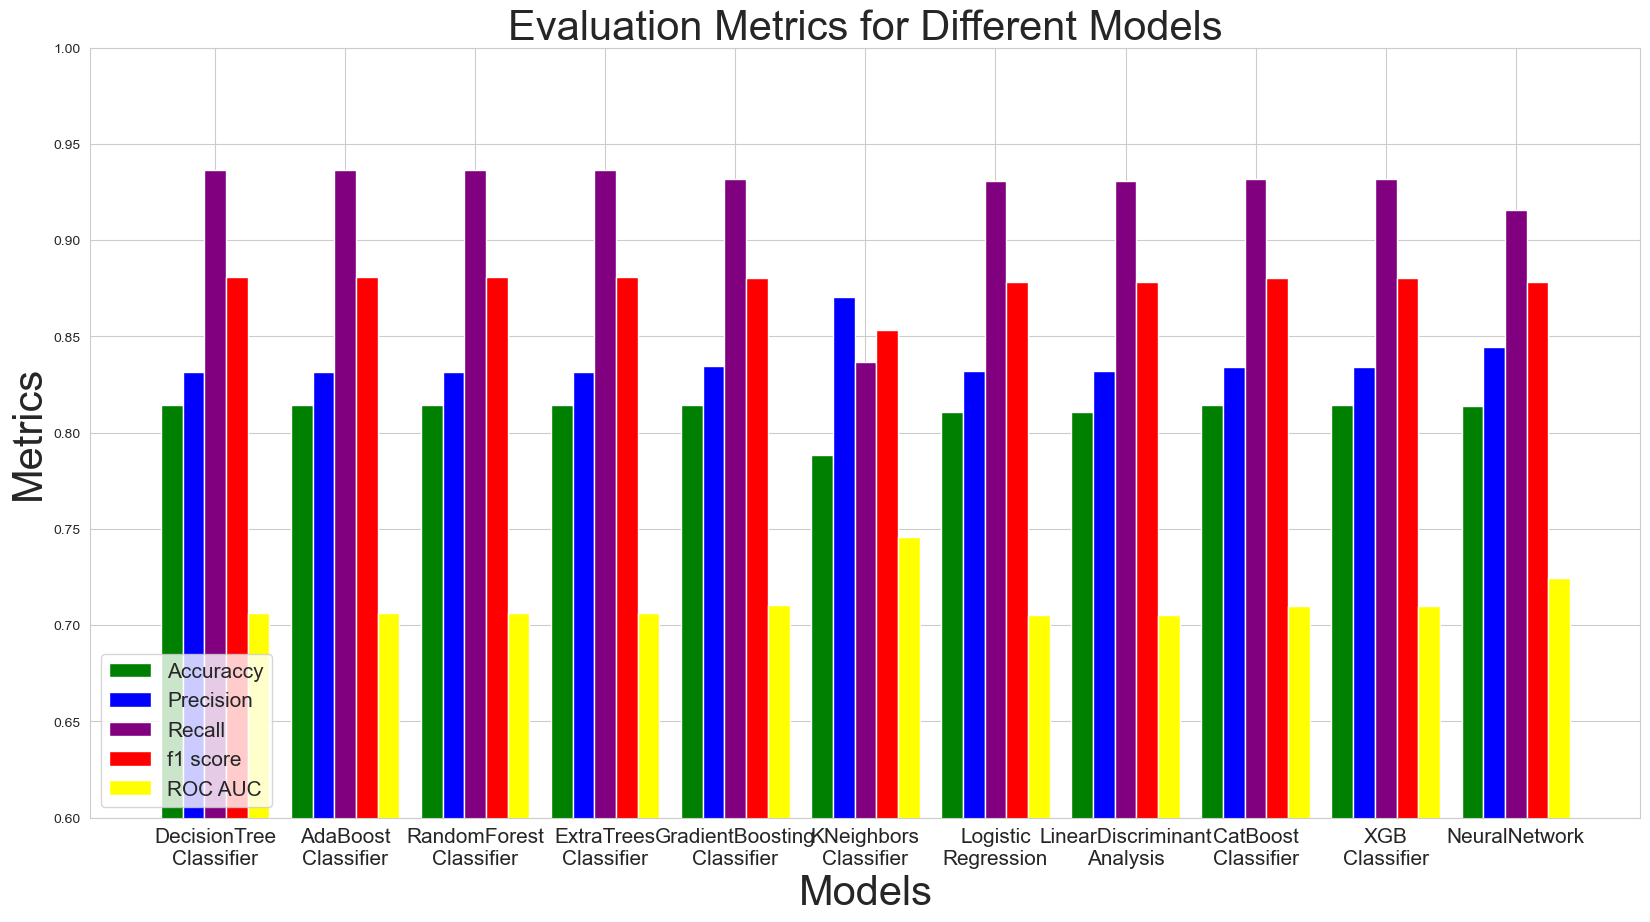

In [44]:
model_names = [type(model).__name__ for model in myModels]
model_names = [name[:-10] + '\nClassifier' if name[-10:] == "Classifier" else name for name in model_names]
model_names[6] = "Logistic\nRegression"
model_names[7] = "LinearDiscriminant\nAnalysis"
model_names[10] = "NeuralNetwork"

length = len(myModels)

ind = np.arange(length)*1.5
width = 0.25

plt.figure(figsize=(20, 10))
bar1 = plt.bar(ind, accuracies, width, color ='green', label = "Accuraccy")
bar2 = plt.bar(ind + width, precisions, width, color ='blue', label = "Precision")
bar3 = plt.bar(ind + width * 2, recalls, width, color ='purple', label = "Recall")
bar4 = plt.bar(ind + width * 3, f1s, width, color ='red', label = "f1 score")
bar5 = plt.bar(ind + width * 4, roc_aucs, width, color ='yellow', label = "ROC AUC")


plt.xticks(ind+width*2,model_names, fontsize = 15)
plt.xlabel("Models", fontsize = 30)
plt.ylabel("Metrics", fontsize = 30)
plt.title("Evaluation Metrics for Different Models", fontsize = 30)
plt.legend(fontsize = 15, loc = "lower left")
plt.ylim(.6,1)
plt.show()

In [45]:
def weighted_harmonic_mean(value1, value2, weight1, weight2):
    return (weight1 + weight2) / (weight1/value1 + weight2/value2)

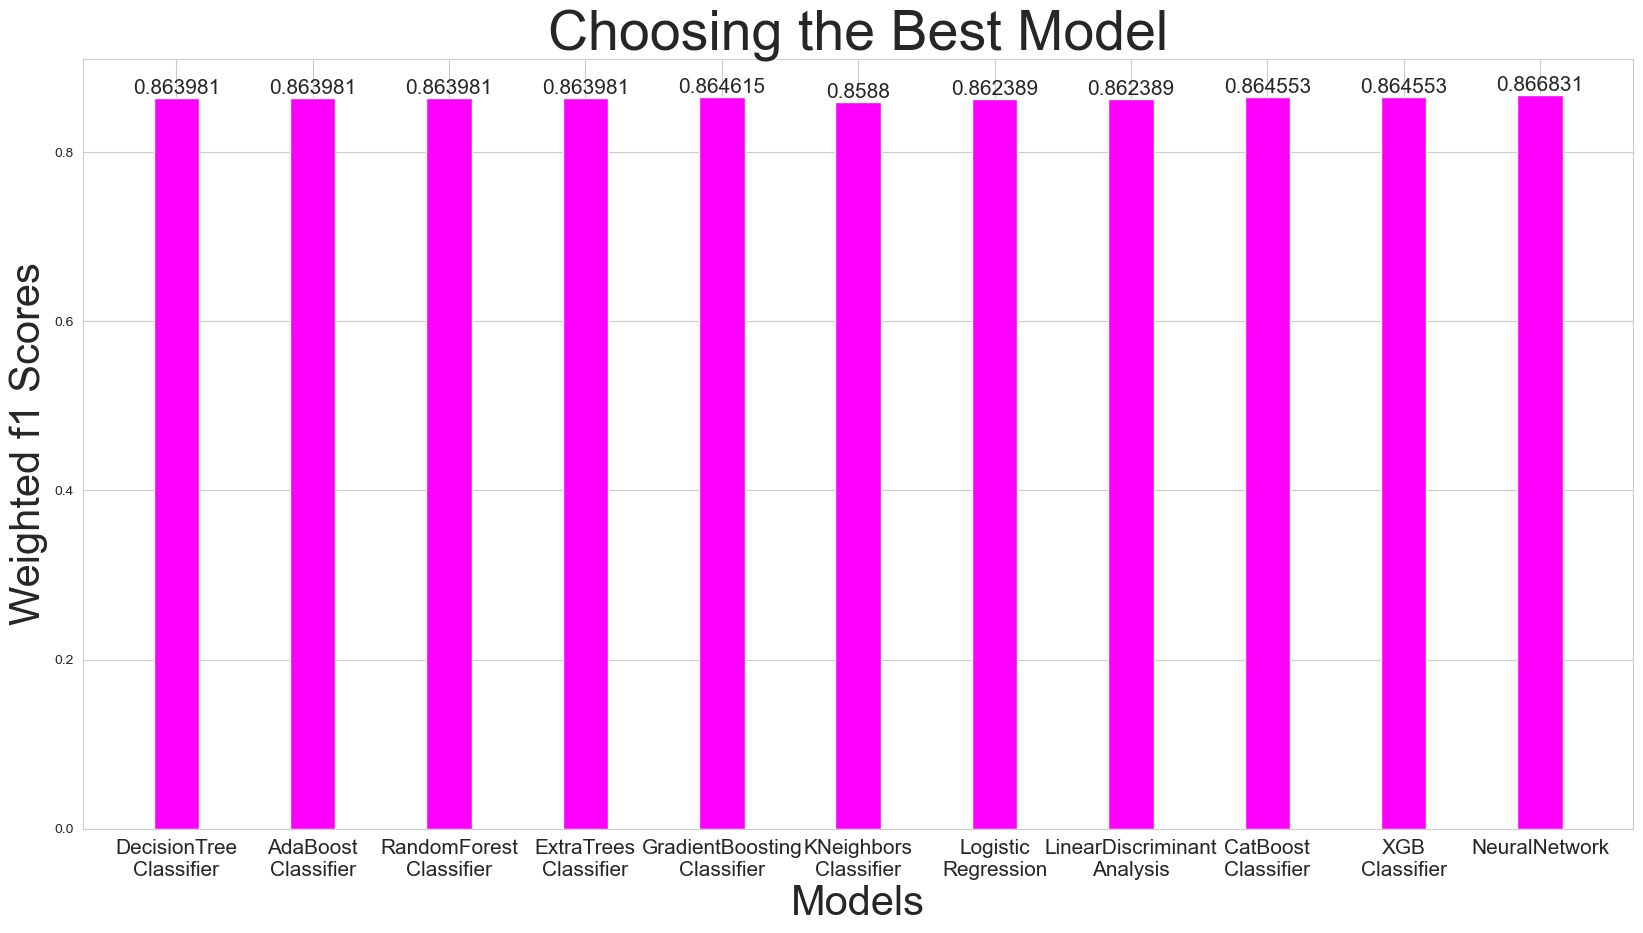

In [46]:
length = len(myModels)
weighted_f1s = np.zeros(length)

precision_weight = 2
recall_weight = 1

for i in range(length):
    weighted_f1s[i] = weighted_harmonic_mean(precisions[i], recalls[i], precision_weight, recall_weight)
    


fig, ax = plt.subplots(figsize=(20,10))
bars = ax.bar(ind, weighted_f1s, color ='magenta', width = 0.5)

plt.xticks(ind,model_names, fontsize = 15)

ax.bar_label(bars, fontsize = 15)
plt.xlabel("Models" , fontsize = 30)
plt.ylabel("Weighted f1 Scores" , fontsize = 30)
plt.title("Choosing the Best Model" , fontsize = 40)
plt.show()

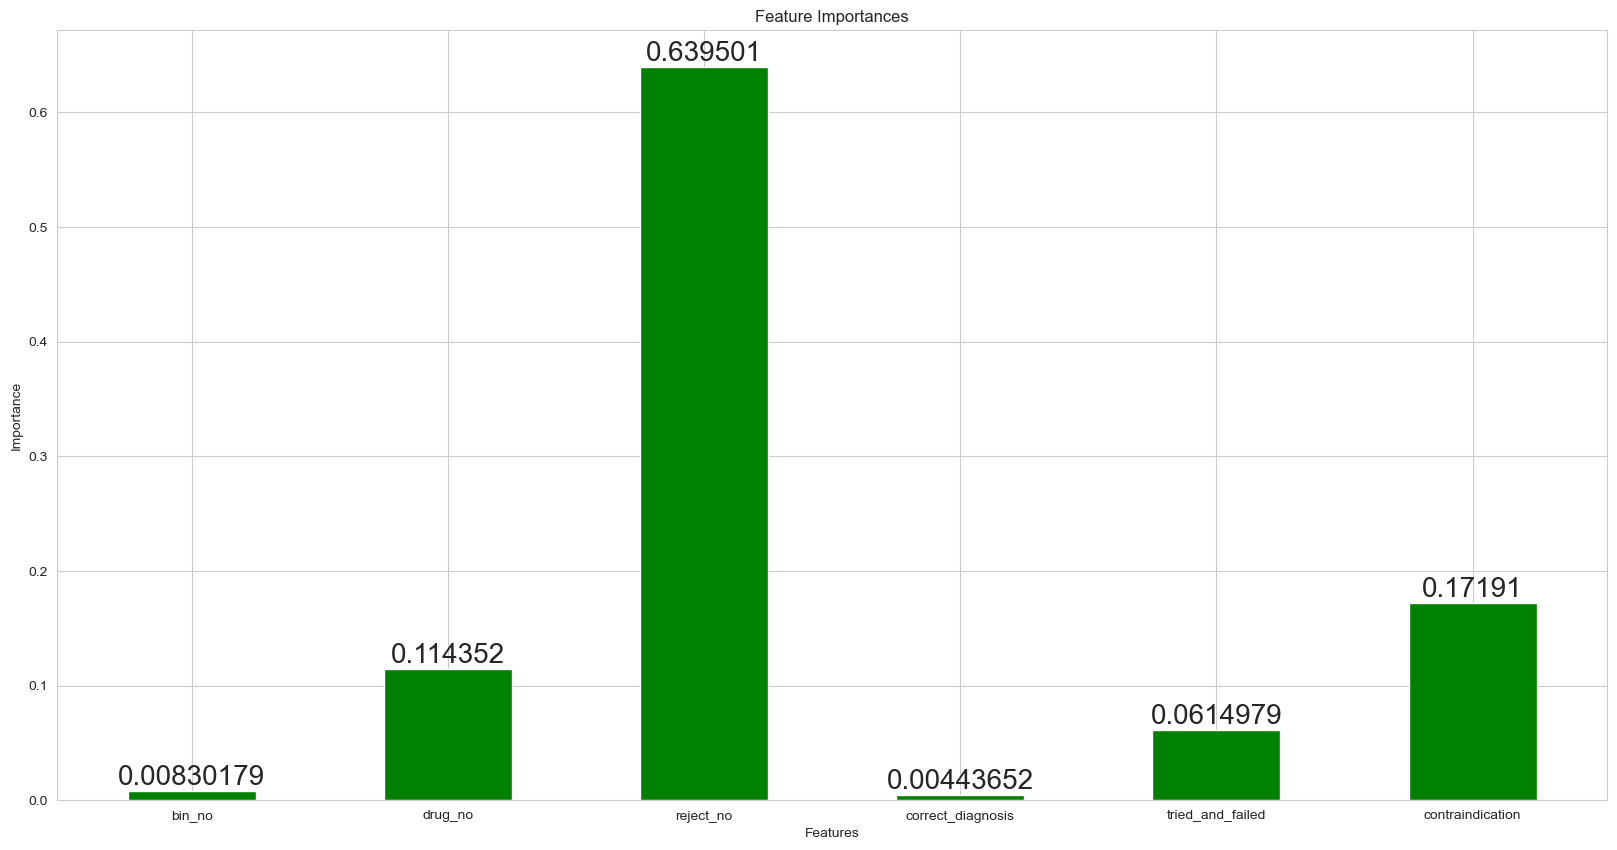

In [50]:
# Bar plot for the feature importances of the GradientBoostClassifier (2nd best model after the neural network)

bestModelIndex = 4  # GradientBoostingClassifier


fig, ax = plt.subplots(figsize=(20,10))
bars = ax.bar(np.array(features).astype(str), myModels[bestModelIndex].feature_importances_, color ='green',
        width = 0.5)

ax.bar_label(bars, fontsize = 20)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

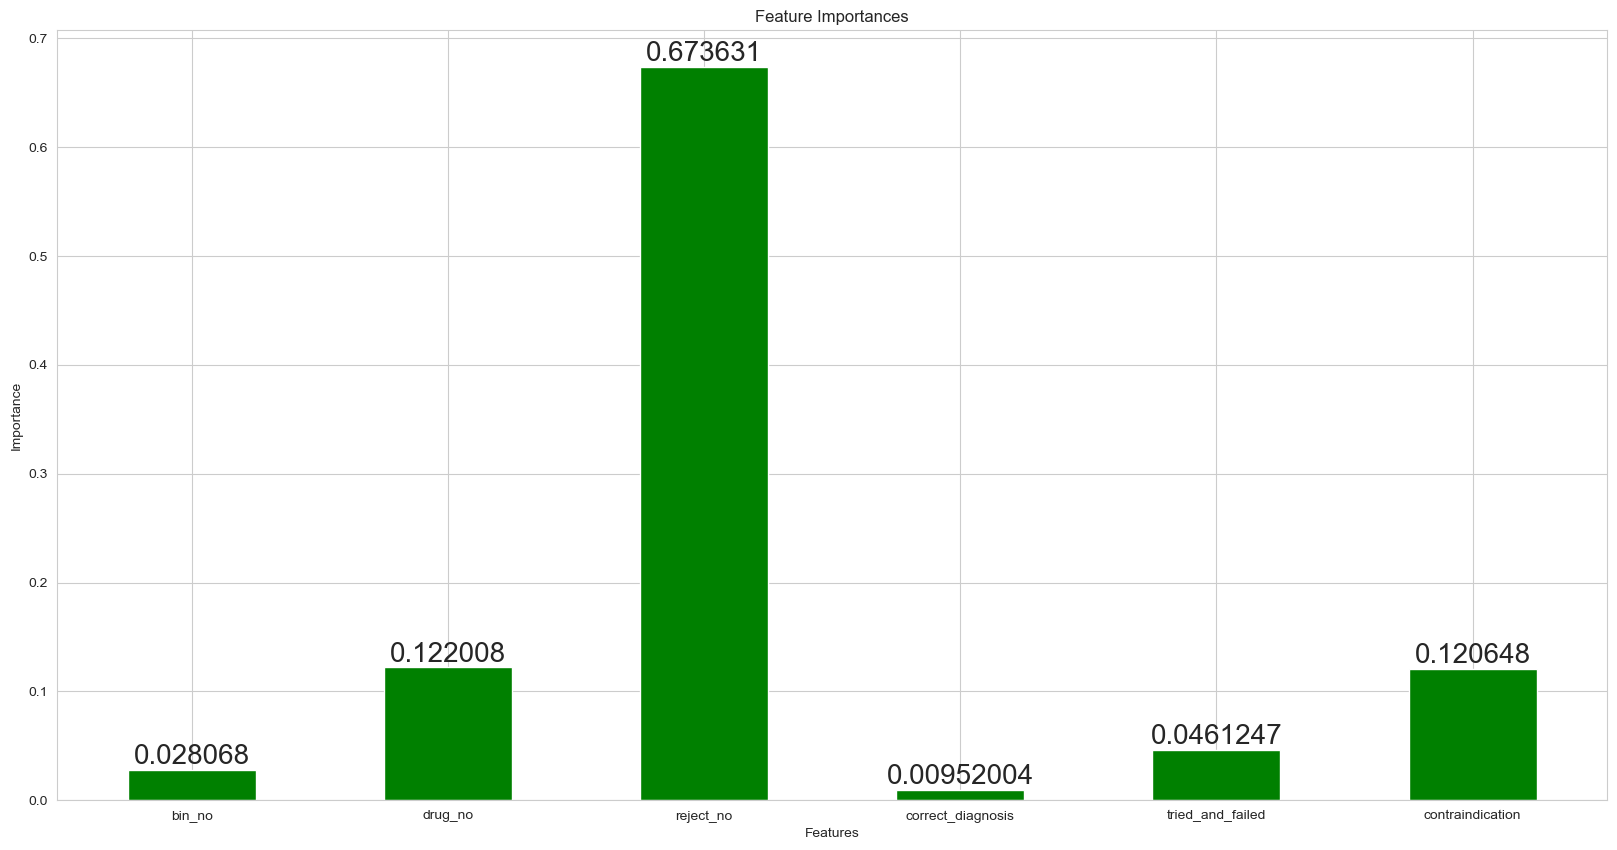

In [52]:
# Bar plot for the feature importances of the GradientBoostClassifier (2nd best model after the neural network)

bestModelIndex = 9  # XGBoost Classifier


fig, ax = plt.subplots(figsize=(20,10))
bars = ax.bar(np.array(features).astype(str), myModels[bestModelIndex].feature_importances_, color ='green',
        width = 0.5)

ax.bar_label(bars, fontsize = 20)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()